In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# "" = CPU
# "0" = GPU_0
# "1" = GPU_1
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
# print( 'CUDA Version =', os.environ['CUDA_VERSION'] )

import sys
print( 'Python Version =', sys.version.split()[0] )

import tensorflow as tf
print( 'Tensorflow Version =',tf.__version__)

print("GPU Available: ", tf.test.is_gpu_available())

Python Version = 3.7.6
Tensorflow Version = 1.15.0
GPU Available:  True


In [5]:
import os
import sys

sys.path.insert(1, '../..')
from os.path import join
from utils_1 import *
import shutil
import gc
from inspect import getsource
import time

from PIL import Image

# from tqdm import tqdm as tqdm
from sklearn.metrics import confusion_matrix

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

import pprint
import math

np.set_printoptions(precision=2)

In [6]:
def get_log(file):
    def write(msg):
        with open( file, 'a' ) as f:
            f.write( '%s\n' % msg )
    
    with open(file, 'w'):
        pass
    
    return write

In [7]:
def iou(y_true, y_pred):
    from tensorflow.keras import backend as K
    
    y_pred    = K.argmax( y_pred, axis=-1 )
    y_pred    = K.one_hot(K.cast(y_pred, 'int32'), num_classes=6)
    y_true_f  = K.flatten( y_true[...,1:] )
    y_pred_f  = K.flatten( y_pred[...,1:] )
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    union     = K.sum(y_true_f + y_pred_f, axis=-1) - intersect
    if union == 0:
        return 1.
    return intersect / union


def dice(y_true, y_pred ):
    from tensorflow.keras import backend as K
    y_pred    = K.argmax( y_pred, axis=-1 )
    y_pred    = K.one_hot(K.cast(y_pred, 'int32'), num_classes=6)
    y_true_f  = K.flatten( y_true[...,1:] )
    y_pred_f  = K.flatten( y_pred[...,1:] )
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom     = K.sum(y_true_f + y_pred_f, axis=-1)
    if denom == 0:
        return 1.
    return 2. * intersect / denom


def cate(y_true, y_pred ):
    from tensorflow.keras.metrics import categorical_accuracy
    return categorical_accuracy(y_true, y_pred)


def loss(y_true, y_pred):
    from tensorflow.keras import backend as K
    
    def dice(y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=axis)
        denom        = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis)
        
        return (2. * intersection + smooth) / (denom + smooth)
    
    def iou(y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=axis)
        union        = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) - intersection
        
        return ( intersection + smooth ) / ( union + smooth )
    
    axis   = [1,2,3]
    smooth = 1
    gamma  = 1.
    loss   = 1 - dice( y_true, y_pred )
    return K.pow( loss, gamma )


def get_model(model_path):
    from tensorflow.keras.models import load_model
    return load_model( model_path ,custom_objects={ 'loss_func':loss, 'loss': loss, 'dice':dice , 'iou': iou, 'cate': cate})

In [8]:
def get_x( path ):
    def get_x_rgb( path ):
        rgb = read_image( path, 'rgb' )
        return rgb / 255

    get_x = get_x_rgb
    x = np.array( get_x(path) ).astype( np.float32 )
    return x

def get_y( path ):
    grayscale = read_image( path, 'gray' ) / color
    layers = [  (grayscale == i) + [0] for i in range(0, num_classes) ]
      
    return np.stack( layers, axis=2 ).astype( np.float32 )

In [9]:
def calculate_iou( y_true, y_pred ):
    y_pred = y_pred[...,1:].flatten()
    y_true = y_true[...,1:].flatten()
    
    intersection = np.sum( y_pred * y_true )
    union = np.sum( y_pred ) + np.sum( y_true ) - intersection
    
    if union == 0.:
        return 100.
    
    iou_score = intersection / union
    return iou_score * 100


def calculate_dice( y_true, y_pred ):
    y_pred = y_pred[...,1:].flatten()
    y_true = y_true[...,1:].flatten()
    
    intersection = np.sum( y_pred * y_true )
    denom        = np.sum( y_pred ) + np.sum( y_true )
    
    if denom == 0.:
        return 100.
    
    dice_score = 2. * intersection / denom
    return dice_score * 100
    
    
def calculate_region_size_error( y_true, y_pred ):
    y_pred = y_pred[...,1:].flatten()
    y_true = y_true[...,1:].flatten()
    
    gt = np.sum(y_true)
    cs = np.sum(y_pred)
    
    if gt == 0.:
        return 100.
    
    region_size_error = abs( gt - cs ) / gt
    return region_size_error * 100

In [10]:
def get_train_dir(Experiment_DIR):
    path = os.path.join( Experiment_DIR, 'detail.txt' )
    with open( path , 'r' ) as file:
        data = file.read()
    
    desc_index = data.find('Description:')
    desc = data[desc_index: data.find( '\n', desc_index)].split(" ")[-1]
    return desc


def get_history( dirs, Experiment_DIR ):
    losses = []
    val_losses = []
    iou_s = []
    val_iou_s = []
    for fold in dirs:
        fold_DIR = os.path.join( Experiment_DIR, fold )
        history_path = os.path.join( fold_DIR, 'history.npy' )
        
        if not is_exists(history_path):
            raise FileNotFoundError(history_path)
        
        history = np.load( history_path, allow_pickle=True )
        logs = history.item()
        
        losses.append( logs['loss'] )
        val_losses.append( logs['val_loss'] )
        
        iou_s.append( logs['iou'] )
        val_iou_s.append( logs['val_iou'] )
    
    losses     = np.array( losses ).T
    val_losses = np.array(val_losses).T
    iou_s      = np.array( iou_s ).T
    val_iou_s  = np.array( val_iou_s ).T
    
    return ( losses, iou_s ) , ( val_losses, val_iou_s )

def window_generator( windows, b_size ):
    def load( windows ):
        x = np.asarray( windows ).astype(np.float32)
        return x
    
    L = len(windows)
    
    while True:
        batch_start = 0
        batch_end = b_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            x     = load( windows[batch_start:limit] )
            yield x
            batch_start += b_size
            batch_end   += b_size



# Config

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix_custom(confusion_matrix_all, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          figsize=(8,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix_all
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
#     print(cm)
    tmp = np.reshape(cm, -1)
    tmp = [0 if math.isnan(x) else x for x in tmp]
    tmp = np.reshape(tmp, cm.shape)
    cm = tmp.copy()
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig


In [12]:
def labelGray2Color(image, color_class):
#     print("unique color: ",np.unique(image))
    # wound tissued
    label_color = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    label_color[image == 0]    = color_class[0]
    label_color[image == color*1] = color_class[1]
    label_color[image == color*2] = color_class[2]
    label_color[image == color*3] = color_class[3]
    label_color[image == color*4] = color_class[4]

    # wound closed
#     label_color = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
#     label_color[image == 0]    = color_class[0]
#     label_color[image == color*1] = color_class[1]
    return label_color

def plot_sample(title, original, label, predict):
    
    raw_label = label.copy()
    raw_predict = predict.copy()
    
    def mergeLabelPred( label, predict):
        label_color = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
        label[label > 0] = 1
        predict[predict > 0] = 1
#         print(label.shape)
#         print(np.unique(label))
        label_color[label > 0] += 80
        label_color[predict > 0] += 160
    
#         print(label_color.shape)
#         print(np.unique(label_color))
        label_color[label_color == 80]  = 255
        label_color[label_color == 160] = 180
        label_color[label_color == 240] = 50

        return label_color
    
    f, (a1, a2, a3, a4, a5) = plt.subplots( 1, 5, figsize=(15,8) )
    f.suptitle( title )
    a1.set_title('Original')
    a1.imshow( original )
    
    a2.set_title('Label')
    label = labelGray2Color(label, color_class)
    im2 = a2.imshow(label)
#     a2.figure.colorbar(im2, ax=a2) 
    
    a3.set_title('Predict')
    predict = labelGray2Color(predict, color_class)
    im3 = a3.imshow( predict)
#     a3.figure.colorbar(im3, ax=a3)
    
    a4.set_title('pred vs label IoU')
    mergeLabelPred = mergeLabelPred( raw_label, raw_predict)
    im3 = a4.imshow( mergeLabelPred )
    
#     print(color_class)
    a5.set(yticks=np.arange(6),
           yticklabels= tmp_labels,
           title='Class Color')
    a5.get_xaxis().set_ticks([])
    re_color_class = color_class
    re_color_class = np.reshape(color_class, (5, 1, 3))
#     print(re_color_class)
    a5.imshow(re_color_class, interpolation='nearest')
    
    return f

def confusion2string(title, confusion, class_names, normalize=False):
#     print(confusion.shape)
#     print(confusion)
#     print(zip(*class_names))
   
    
    temp_lines = ['{}:'.format(title),
                 "%15s %15s %15s %15s %15s %15s" % ('actual\\predict', *class_names)]
    if normalize == True:
        cm = confusion.copy()
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        tmp = np.reshape(cm, -1)
        tmp = [0. if math.isnan(x) else x if x != 0. else -1 for x in tmp]
        tmp = np.reshape(tmp, confusion.shape)
        confusion = tmp
        for i, data in enumerate(confusion):
#             temp_lines += ["%15s %15s %15s %15s %15s %15s %15s" % (class_names[i], *["{:,}".format(round(x, 2)) if x > 0 else "-" for x in data])]
            temp_lines += ["%15s %15s %15s %15s %15s %15s" % (class_names[i], *["{:,.3f}".format(x) for x in data])]
#             temp_lines += ["%15s %15s %15s" % (class_names[i], *["{:,.3f}".format(x) for x in data])]
    
    else:
        for i, data in enumerate(confusion):
            temp_lines += ["%15s %15s %15s %15s %15s %15s" % (class_names[i], *["{:,}".format(int(x)) for x in data])]
#             temp_lines += ["%15s %15s %15s" % (class_names[i], *["{:,}".format(int(x)) for x in data])]

    return '\n'.join(temp_lines) + "\n\n"

def genReport(non_bg_iou_list, iou_list, dice_list, rse_list, time_list, confusion_matrix_all, class_names, image_names, model_path, normalize=0):
    log = "model_path : %s \n\n" % (model_path)
    log += '\t'.join(
            [ "%s" % "image_name"] + list( map(lambda x: '%5s' % x, ["non_bg_iou", "IoU", "Dice", "RSE", "Time"]) ) 
            ) + "\n"
    for i in range(len(iou_list)):
        non_bg_iou, iou_, dice_, rse_, time_, image_name = non_bg_iou_list[i], iou_list[i], dice_list[i], rse_list[i], time_list[i], image_names[i]
        log += '\t'.join(
                [ "%s" % image_name] + list( map(lambda x: '%-3.2f' % x, [non_bg_iou, iou_, dice_, rse_, time_]) ) 
                ) + "\n"
    
    mean_iou       = np.mean( iou_list )
    mean_dice      = np.mean( dice_list )
    mean_rse       = np.mean( rse_list )
    mean_bg_iou    = np.mean( non_bg_iou_list )
    
    log += "\n" + '\n'.join(["{}\t{:.4f}".format(x[0], x[1]) for x in 
                             list(zip(["mean_bg_iou", "mean_iou", "mean_dice", "mean_rse"],[mean_bg_iou, mean_iou, mean_dice, mean_rse]))]) + "\n\n"
    
    summary_confusion = confusion2string(title="Summary Confusion Matrix", confusion=
                           confusion_matrix_all, class_names=class_names)
    log += summary_confusion
    
    summary_confusion_normalize = confusion2string(title="Summary Confusion Matrix Normalize", confusion=
                           confusion_matrix_all, class_names=class_names, normalize=True)
    log += summary_confusion_normalize
    
    return log

In [13]:
def evaluate_sample_sub( model, f_path, l_path ):
    tic = time.time()
    f_img = get_x(f_path)
    l_img = get_y(l_path)
    
    f_windows = [ f_img ]
    win_gen = window_generator( f_windows, b_size )
    
    y_pred = model.predict_generator(
        generator=win_gen,
        steps=len(f_windows) / b_size
    )
    y_ori_pred = y_pred.squeeze()
    
    y_pred = np.eye( num_classes )[y_ori_pred.argmax(axis=-1 )]
    y_true = l_img
    
    iou_  = calculate_iou( y_true, y_pred )
    dice_ = calculate_dice( y_true, y_pred )
    rse_  = calculate_region_size_error( y_true, y_pred )
    confusion   = confusion_matrix( y_true.argmax(axis=-1 ).flatten(), y_pred.argmax(axis=-1 ).flatten(), labels=[0,1,2,3,4] )
    
    segmented = y_ori_pred.argmax(axis=-1 ) * color
    
    def calculate_non_bg_iou( y_true, y_pred ):
        y_pred = y_pred.flatten()
        y_true = y_true.flatten()
        y_pred[y_pred > 0] = 1 
        y_true[y_true > 0] = 1

        intersection = np.sum( y_pred * y_true )
        union = np.sum( y_pred ) + np.sum( y_true ) - intersection

        if union == 0.:
            return 100.

        iou_score = intersection / union
        return iou_score * 100
    
    tmp_l_img = l_img.argmax(axis=-1 ) * 51
    non_bg_iou = calculate_non_bg_iou(tmp_l_img, segmented)
    
    
    toc = time.time()
    return iou_, dice_, rse_, segmented, confusion, toc - tic, non_bg_iou

def evaluate(model, sub_original_image_paths, sub_label_image_paths,
             evaluate_dir, evaluate_image_dir, evaluate_fig_dir, 
             log_name, model_path, num_sub_original_images, verbose=0, showfig=0):

    if model == None:
        pprint.pprint(evaluate_image_dir)
        return
    
    tic           = time.time()
    temp_sort_iou = {}
    iou_list      = []
    dice_list     = []
    rse_list      = []
    time_list     = []
    image_names   = []
    non_bg_iou_list = []
    confusion_matrix_all= np.zeros(shape=(num_classes, num_classes))
    sengmented_images   = []
    
    try:
        flod_number = short_model_path.split(os.sep)[2]
#         print(flod_number)
        flod_number = int(flod_number)
    except:
        flod_number = "eval"
    
#     for i in tqdm( range(num_sub_original_images), desc='Sub-Image:' ):
    tmp_index = 1
    for i in range(num_sub_original_images):
        original_img_path = sub_original_image_paths[i]
        label_img_path = sub_label_image_paths[i]
  
        iou_, dice_, rse_, segmented, con, time_, non_bg_iou = evaluate_sample_sub(model, original_img_path, label_img_path)
    
#         new_image_name = "{}-IoU-{:0.4f}.png".format(str(tmp_index).zfill(4), iou_)
        new_image_name = "IoU-{:0.10f}.png".format( iou_)
        temp_sort_iou[new_image_name] = [new_image_name, original_img_path, label_img_path, iou_, dice_, rse_, segmented, con, time_, non_bg_iou]
        
        tmp_index += 1
        
#     pprint.pprint(temp_sort_iou)
    tmp_sort = sorted(temp_sort_iou.items(), key=lambda x: x[1][3], reverse=True)
    _, full_sort = zip(*tmp_sort)
    for image_name, original_img_path, label_img_path, iou_, dice_, rse_, segmented, confusion, time_, non_bg_iou in full_sort:
#         mean_iou       = np.mean( iou_list )
#         mean_dice      = np.mean( dice_list )
#         mean_rse       = np.mean( rse_list )
        non_bg_iou_list.append(non_bg_iou)
        iou_list.append(iou_)
        dice_list.append(dice_)
        rse_list.append(rse_)
        sengmented_images.append(segmented)
        time_list.append(time_)
        image_names.append(image_name)
        confusion_matrix_all += con

    log = genReport(non_bg_iou_list, iou_list, dice_list, rse_list, time_list, confusion_matrix_all, class_names, image_names, model_path )
#     print(log)
    with open(os.path.join(log_name), 'a+') as f:
        f.write(log)

    tmp_key = [x[0] for x in tmp_sort[:10]] + [x[0] for x in tmp_sort[-10:]]
#     print(len(tmp_key))
    set_key = ()
    for key in tmp_key:
        if not key in set_key:
            set_key += (key,)
#     print(len(set_key))
    new_sort = [temp_sort_iou[key] for key in set_key]
#     Save image
    tmp_index = 1
    for image_name, original_img_path, label_img_path, iou_, dice_, rse_, segmented, confusion, time_, non_bg_iou in new_sort:
        
        new_image_name = "{}-IoU-{:0.6f}.png".format(str(tmp_index).zfill(4), iou_)
#         new_image_name = image_name
        
        if verbose == True:
            
#             sub_fig_dir = os.path.join(evaluate_fig_dir, flod_number)
#             os.makedirs(sub_fig_dir, exist_ok=True)
            
#             fig_image_path          = os.path.join(sub_fig_dir , flod_number + "-" +label_img_path.split(os.sep)[-1].replace(".png", "_fig.png"))
#             print(fig_image_path)
           
            os.makedirs(evaluate_fig_dir, exist_ok=True)
            fig_image_path          = os.path.join(evaluate_fig_dir , new_image_name)
#             print(fig_image_path)

            feature_img             = cv2.cvtColor(cv2.imread(original_img_path), cv2.COLOR_BGR2RGB)
            label_image             = cv2.imread(label_img_path, cv2.IMREAD_GRAYSCALE)
            tmp_title = [new_image_name] 
            tmp_title += ["{: >12}:{:.2f}".format(x[0], x[1]) for x in list(zip(["iou", "non_bg_iou", "mean_dice", "mean_rse"], [iou_, non_bg_iou, dice_, rse_, time_]))]
            title_fig = "".join(tmp_title)
            fig_image               = plot_sample(title_fig, feature_img, label_image, segmented)
            if SAVE_IMAGE == True:
                fig_image.savefig(fig_image_path)
#             predict_image_path      = os.path.join(evaluate_image_dir , label_img_path.split(os.sep)[-1])
#             cv2.imwrite(predict_image_path, segmented)

    #         sub_confusion = confusion2string(title="Sub-Confusion Matrix", confusion= confusion, class_names=class_names)
    #         log += sub_confusion
        
        if showfig == True:
#             sub_image_dir = os.path.join(evaluate_image_dir, flod_number)
#             os.makedirs(sub_image_dir, exist_ok=True)
            
#             fig_cufusion_path       = os.path.join(sub_image_dir , flod_number + "-" +label_img_path.split(os.sep)[-1].replace(".png", "_confusion.png"))
#             print(fig_cufusion_path)

            os.makedirs(evaluate_image_dir, exist_ok=True)
            fig_cufusion_path       = os.path.join(evaluate_image_dir, new_image_name)
#             print(fig_cufusion_path)
            
            fig_confusion           = plot_confusion_matrix_custom(confusion.astype(int), 
                                                            classes   = class_names,
                                                            title     ='Confusion matrix :' + new_image_name,
                                                            normalize = True,
                                                            figsize   = (5,5))
            if SAVE_IMAGE == True:
                fig_confusion.savefig(fig_cufusion_path)
        tmp_index += 1
        
        
    
   
    
    return non_bg_iou_list, iou_list, dice_list, rse_list, time_list, confusion_matrix_all, class_names, image_names, model_path, sengmented_images

In [14]:
def eval_Kfold(dst_dir, experiments_dir, model_name, root, sub_original_image_paths, sub_label_image_paths, num_sub_original_images, fold_dirs = None):
    log_name            = os.path.join(dst_dir, "log-{}.txt".format(time.time()))
    experiment_lists    = {}
    for fold_dir in fold_dirs:
        full_experiment_dir = os.path.join(experiments_dir, fold_dir)
        
        evaluate_image_dir    = os.path.join(dst_dir, fold_dir, "confusion_matrixs")
        evaluate_fig_dir      = os.path.join(dst_dir, fold_dir, "images")
        experiment_model_path = os.path.join(experiments_dir, fold_dir, model_name + "_model.h5")
        short_model_path      = experiment_model_path.replace(root, "")
        
        evaluate_result_dir = {
                "evaluate_dir"             : dst_dir, 
                "evaluate_image_dir"       : evaluate_image_dir,
                "evaluate_fig_dir"         : evaluate_fig_dir,
                "sub_original_image_paths" : sub_original_image_paths,
                "sub_label_image_paths"    : sub_label_image_paths,
                "log_name"                 : log_name,
                "num_sub_original_images"  : num_sub_original_images,
                "showfig"                  : 1,
                "verbose"                  : 1,
                "model_path"               : short_model_path,
        }
        if os.path.isfile(experiment_model_path):
            print("evaluate model: ", short_model_path)
#             print(full_experiment_dir)
#             print(evaluate_image_dir)
#             print(evaluate_fig_dir)
#             print()
            gc.collect()
            tmp_model = get_model(experiment_model_path)
            log = short_model_path + "\n\n" 
            
            with open(os.path.join(log_name), 'a+') as f:
                f.write(log)
            
            non_bg_iou_list, iou_list, dice_list, rse_list, time_list, confusion_matrix_all, class_names, image_names, model_path, sengmented_images = evaluate(model=tmp_model, **evaluate_result_dir)
            
            experiment_lists[short_model_path] = dict( mean_iou             = np.mean( iou_list ),
                                                       mean_dice            = np.mean( dice_list ),
                                                       mean_rse             = np.mean( rse_list ),
                                                       non_bg_iou_list = np.mean( non_bg_iou_list ))
            
            flod_number = short_model_path.split(os.sep)[2]
            cfm_dir     = os.path.join(dst_dir, "{}-confusion-normalize.png".format(fold_dir))
            
            plot_confusion_matrix_custom(confusion_matrix_all.astype(int), classes=class_names, title='Confusion matrix, with normalization', normalize=True).savefig(cfm_dir)
            
            cfm_normalize_dir = os.path.join(dst_dir, "{}-confusion.png".format(fold_dir))
            plot_confusion_matrix_custom(confusion_matrix_all.astype(int), classes=class_names, title='Confusion matrix, without normalization').savefig(cfm_normalize_dir)
            
            del tmp_model
            gc.collect()
        else:
            print ("File not exist :", experiment_model_path.replace(root, ""))
            
    tmp_label = ["non_bg_iou_list", "mean_iou", "mean_dice", "mean_rse"]
    
    experiment_lists_sort_IoU = sorted(experiment_lists.items(), key=lambda item: item[1]["mean_iou"], reverse=True)
#     pprint.pprint(experiment_lists_sort_IoU)        
#     print(len(experiment_lists_sort_IoU))
    log = "%15s \t"% "Experiment" + "\t".join(["%15s " % key for key in tmp_label]) + "\n\n"
    for i in experiment_lists_sort_IoU:
        log += "%15s \t" % i[0] + "\t".join(["%15s " % i[1][key] for key in tmp_label]) + "\n"
    print(log)
    print(dst_dir)
    with open(os.path.join(dst_dir, "evaluate_experiment.txt"), 'w+') as f:
        print("create summary text")
  
        f.write(log)
       
    return experiment_lists_sort_IoU

In [17]:
window_height = 512
window_width  = 512
window_shape  = (window_height, window_width)
color         = 63
num_classes   = 5
SAVE_IMAGE    = True

color_class = [(0, 0, 0), (128, 0, 64), (230, 0, 0),  (255, 255, 102), (255, 153, 102)]
tmp_labels  = ['background', 'necrosis', 'granulation', 'slough', 'epithelial']
class_names = ['background', 'necrosis', 'granulation', 'slough', 'epithelial']
b_size      = 1

def test(experiment_number, fold_dirs, training_name, testing_name):
    start_time = time.process_time()
    print(start_time)
    # dataset_name        = "wound_rajavithi"
#     training_name        = "wound_rajavithi_korean_medetec"

#     experiment_number   = "0000"
#     fold_dirs           = ["2","5","8"]
    # fold_dirs           = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
    # fold_dirs           = ["1", "2", "3", "4", "5", "6", "7"]

    model_name          = "best"
    # testing_name        = "training"
    # testing_name        = "testing_korean"
    # testing_name        = "testing_korean_medetec"
    # testing_name        = "testing"
    # testing_name        = "testing_with_rotation"
    # testing_name        = "testing_with_rotation_color"

    type_wound_name     = "wound_tissue"
    
    root                = os.path.join("..", "..", "..", "data", training_name, "wound_segmentation", type_wound_name)
    experiment_dir      = os.path.join(root, "experiments", experiment_number) 
    experiment_dir      = os.path.join(root, "experiments", experiment_number) 

    src_dir             = os.path.join(root, testing_name)
    dst_dir             = os.path.join(root, "evaluate", experiment_number, testing_name)


    # log_name            = os.path.join(dst_dir, "log-one-{}.txt".format(time.time()))

    os.makedirs(dst_dir, exist_ok=True)

    sub_f_original_DIR = join(src_dir, 'feature')
    sub_l_original_DIR = join(src_dir, 'label')

    sub_paths = get_list_dir(sub_f_original_DIR)
    # sub_paths = sorted(sub_paths, key= lambda x: int(x.replace(".png", "")))

    sub_original_image_paths = [ join( sub_f_original_DIR, p) for p in sub_paths ]
    sub_label_image_paths    = [ join( sub_l_original_DIR, p) for p in sub_paths ]
    num_sub_original_images  = len(sub_original_image_paths)
    # num_sub_original_images = 2
    # num_sub_original_images = 50

    print(dst_dir)
    print("image size: ", num_sub_original_images)
    eval_Kfold(dst_dir, experiment_dir, model_name, root, sub_original_image_paths, sub_label_image_paths, num_sub_original_images, fold_dirs)
    end_time = time.process_time()
    print(end_time)
    print(end_time - start_time)

64.613350294
../../../data/wound_rajavithi_korean_medetec/wound_segmentation/wound_tissue/evaluate/0005/testing
image size:  9
evaluate model:  /experiments/0005/5/best_model.h5
evaluate model:  /experiments/0005/6/best_model.h5
evaluate model:  /experiments/0005/7/best_model.h5
     Experiment 	non_bg_iou_list 	       mean_iou 	      mean_dice 	       mean_rse 

/experiments/0005/5/best_model.h5 	75.77599589173673 	53.96923715377914 	68.83479551938568 	12.449907403728469 
/experiments/0005/7/best_model.h5 	72.82746590663176 	52.21090031330336 	66.07019841712169 	22.552003417420856 
/experiments/0005/6/best_model.h5 	72.8788967558562 	50.78783044832534 	64.9570927089274 	17.575256986014242 

../../../data/wound_rajavithi_korean_medetec/wound_segmentation/wound_tissue/evaluate/0005/testing
create summary text
355.955647418
291.342297124


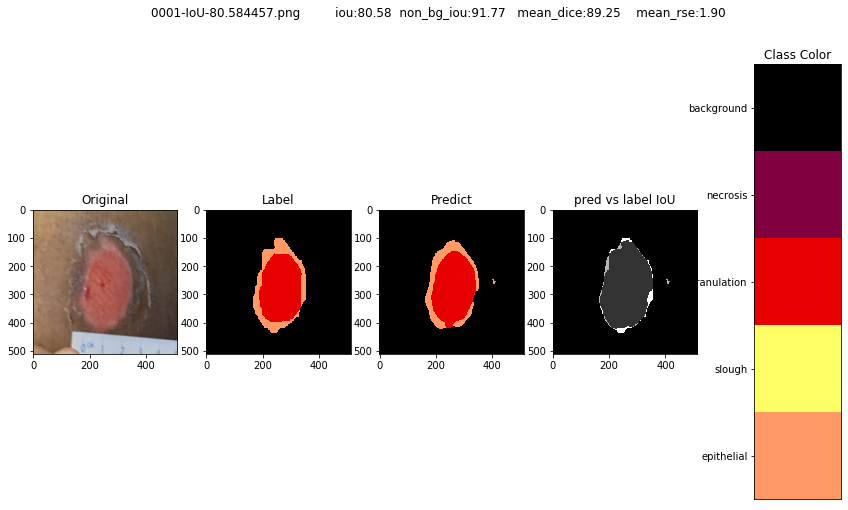

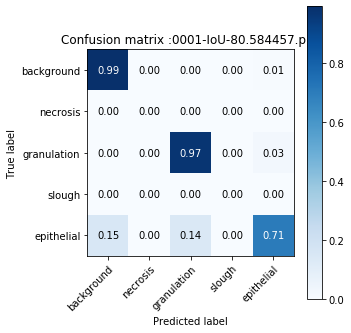

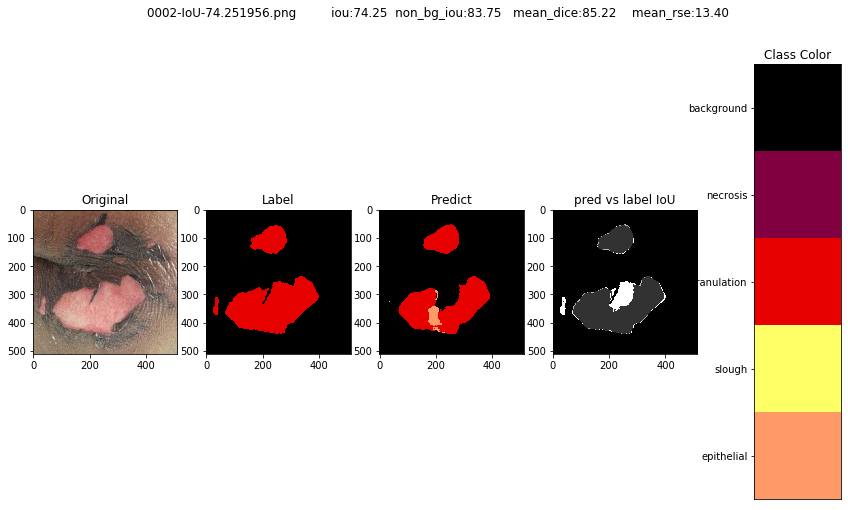

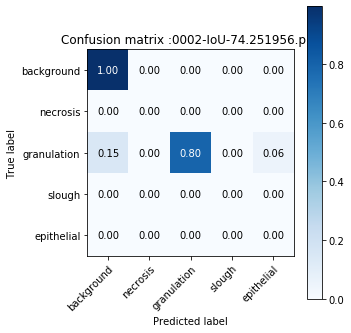

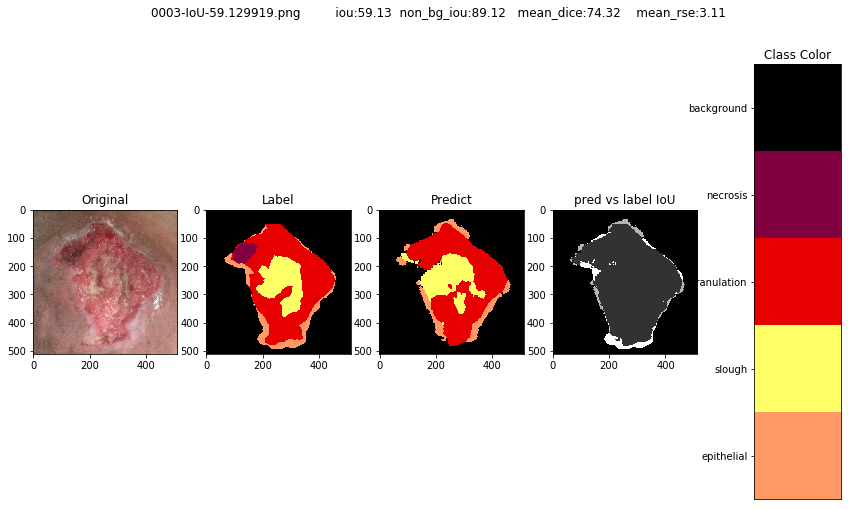

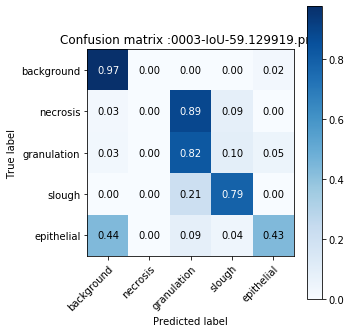

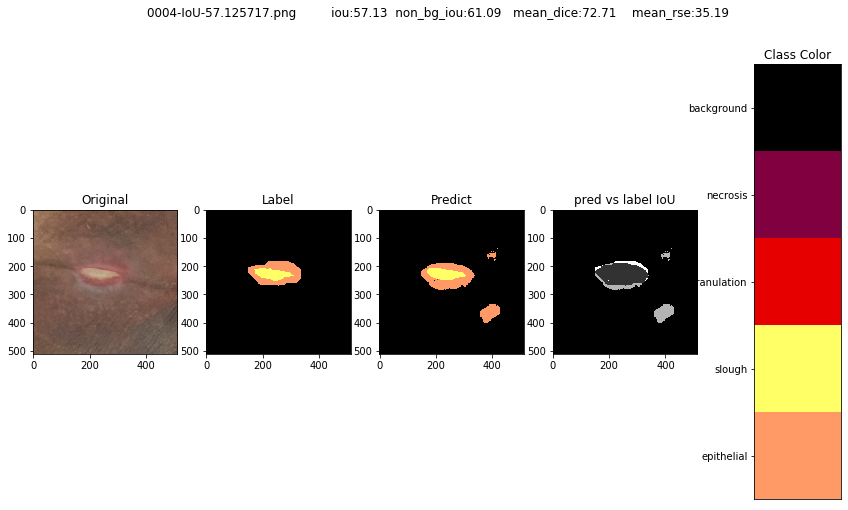

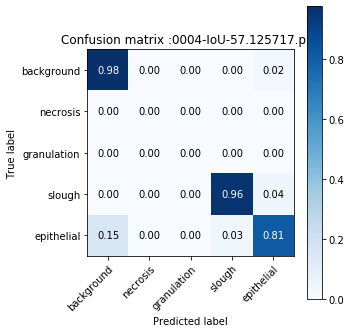

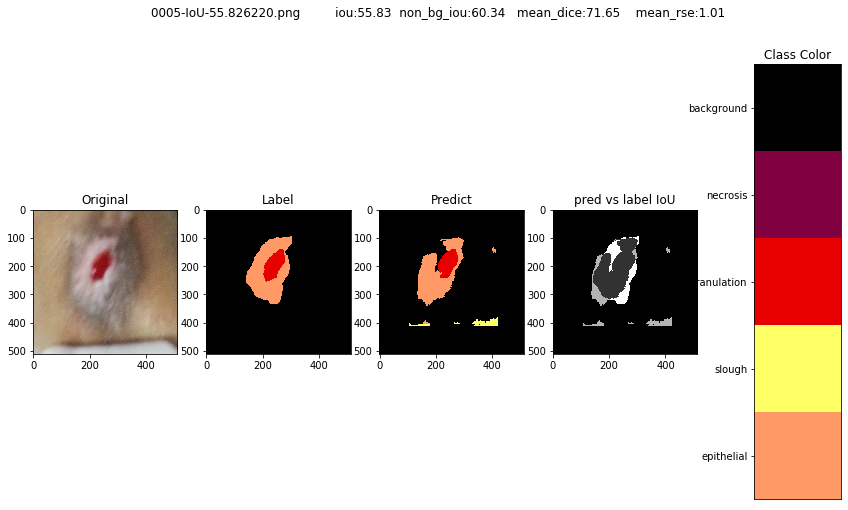

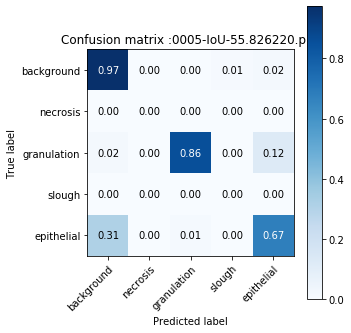

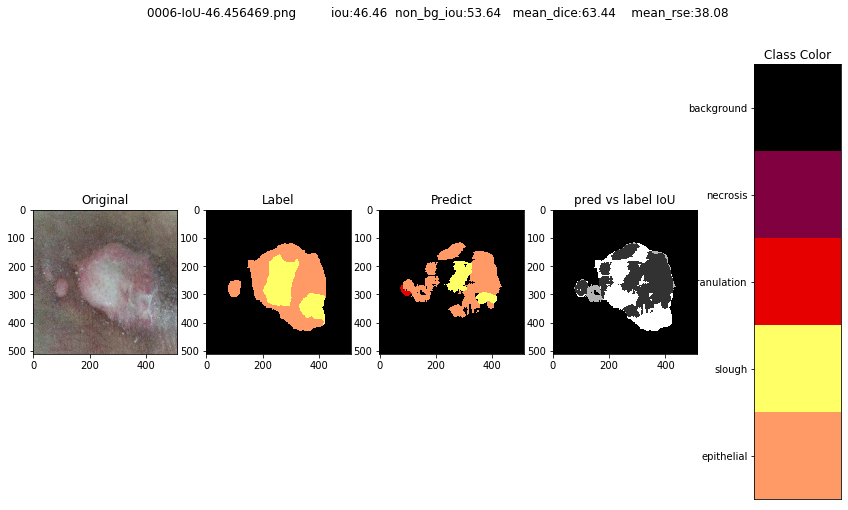

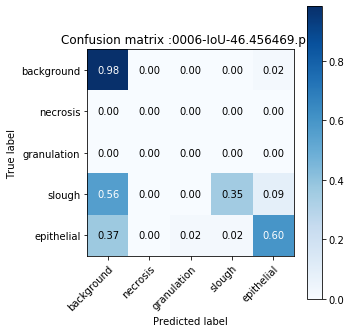

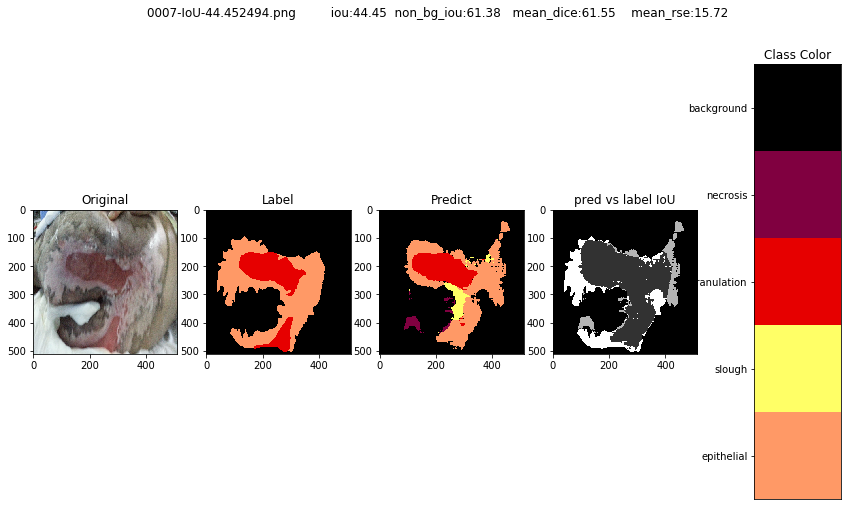

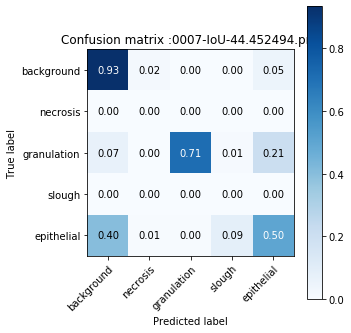

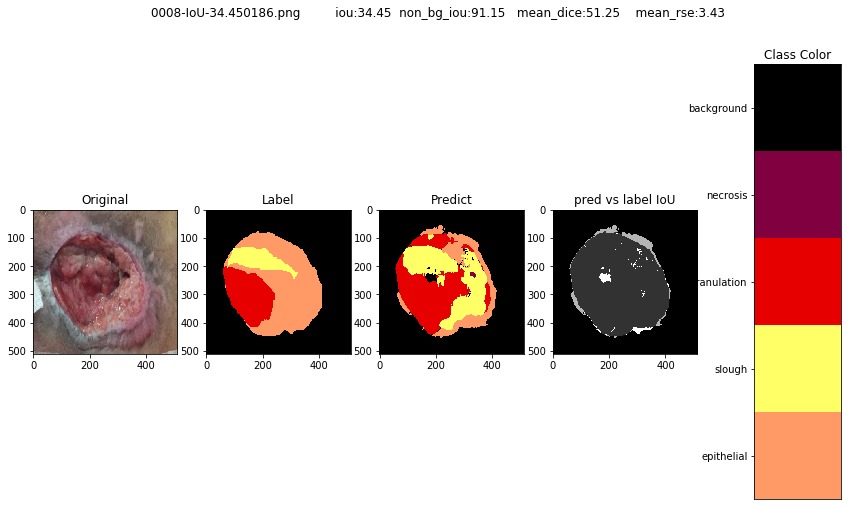

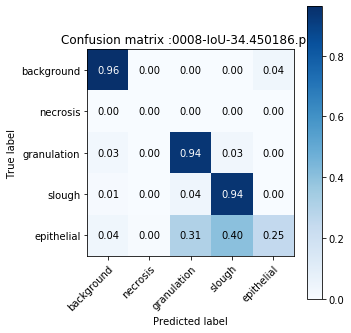

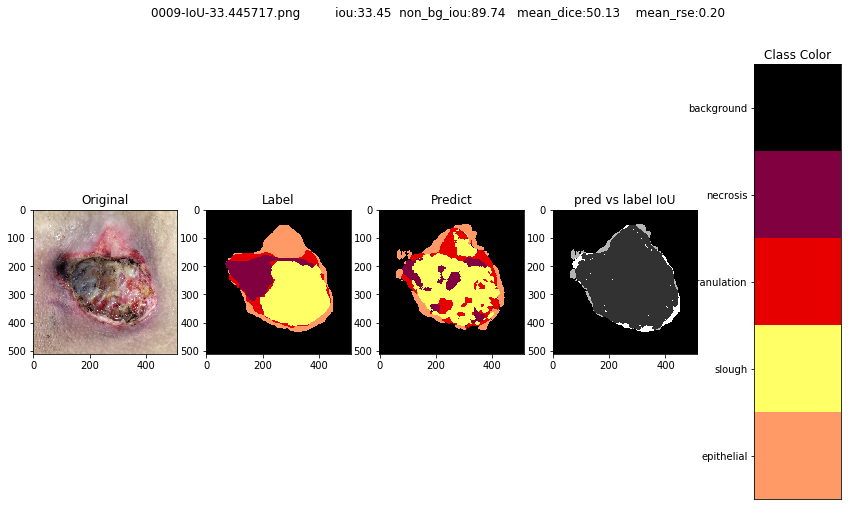

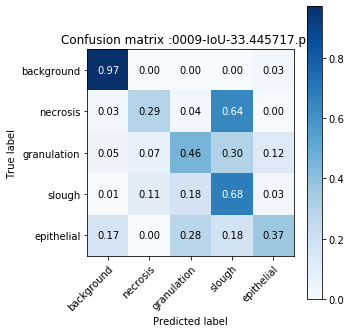

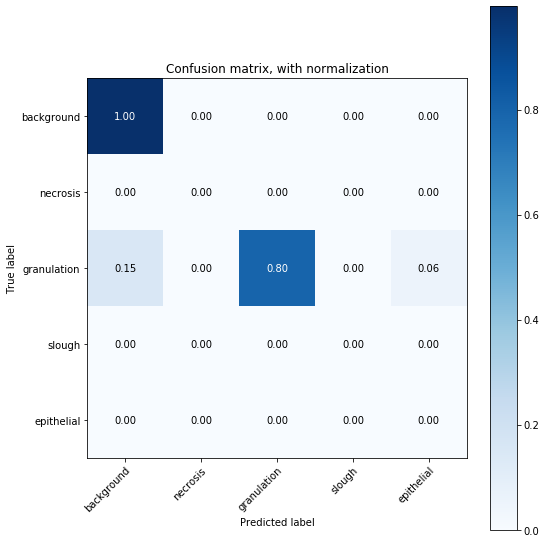

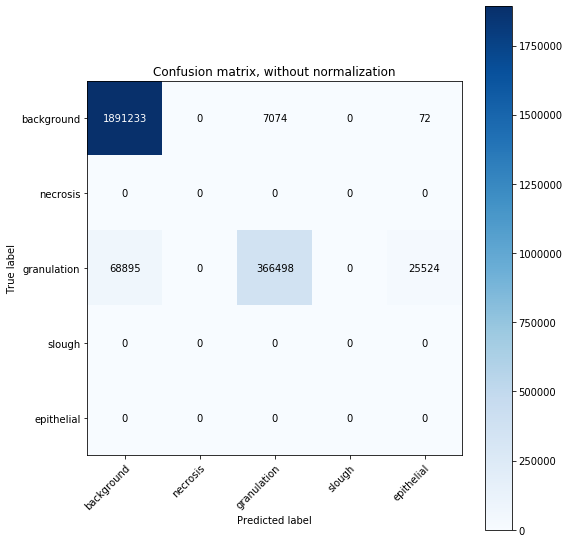

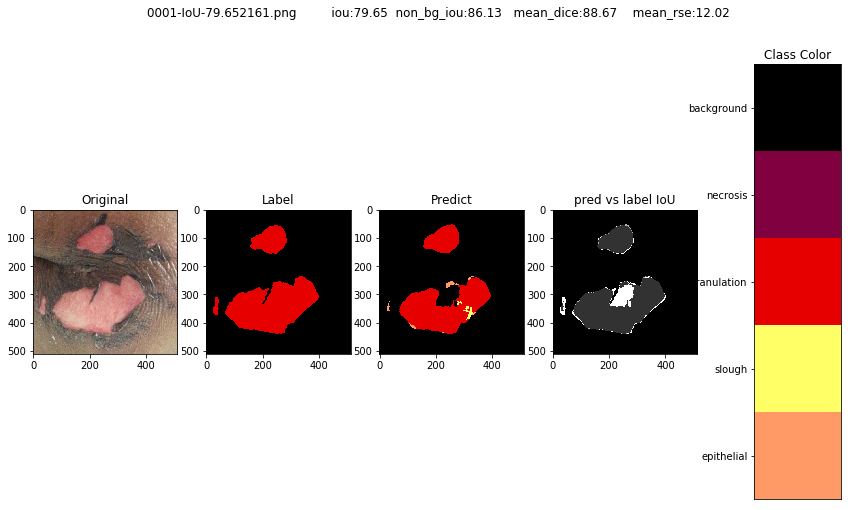

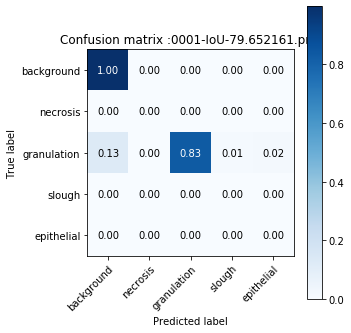

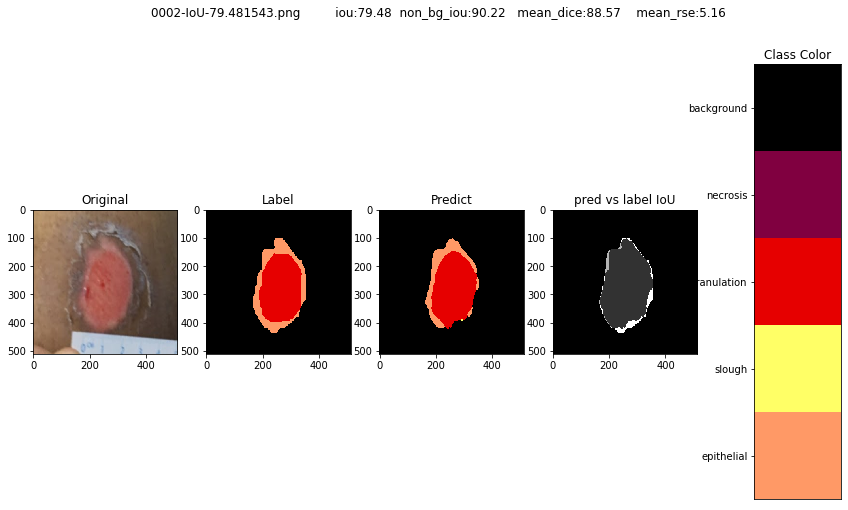

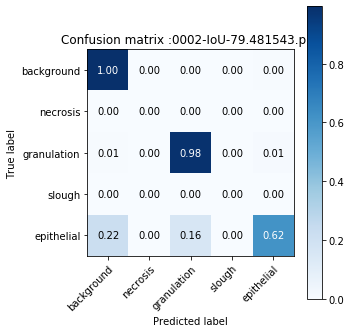

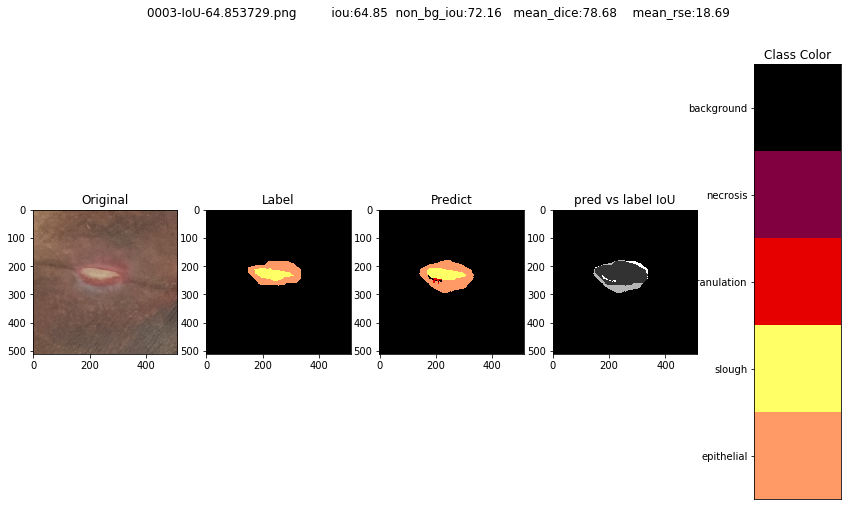

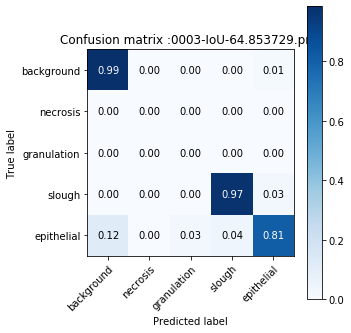

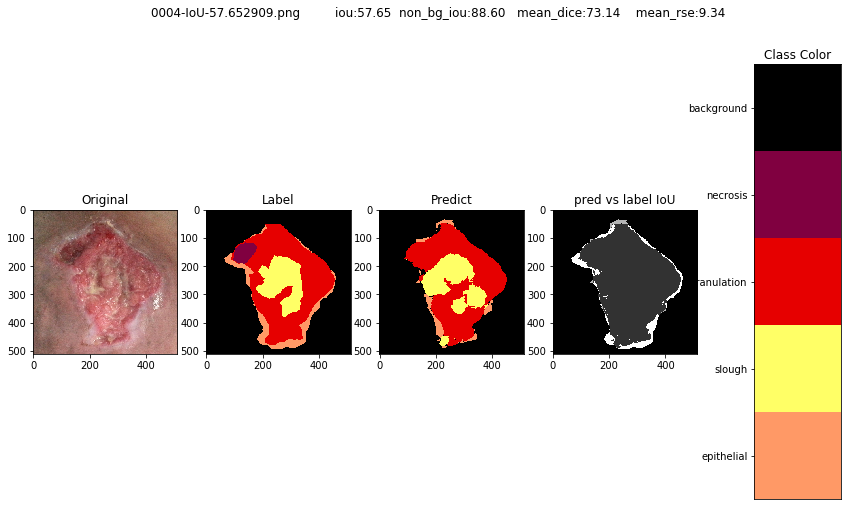

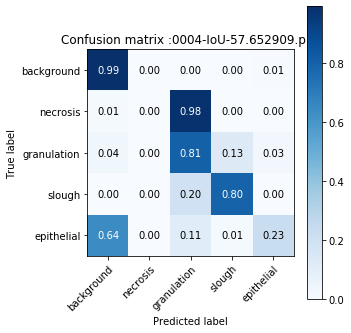

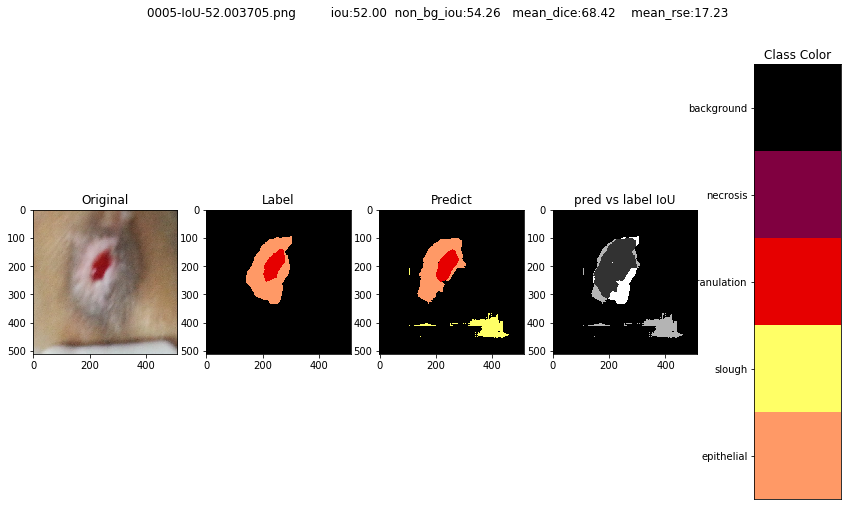

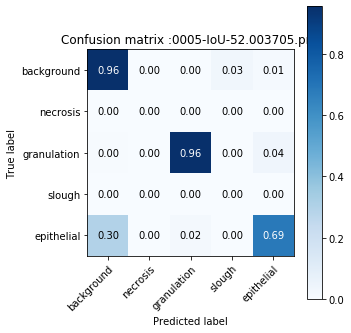

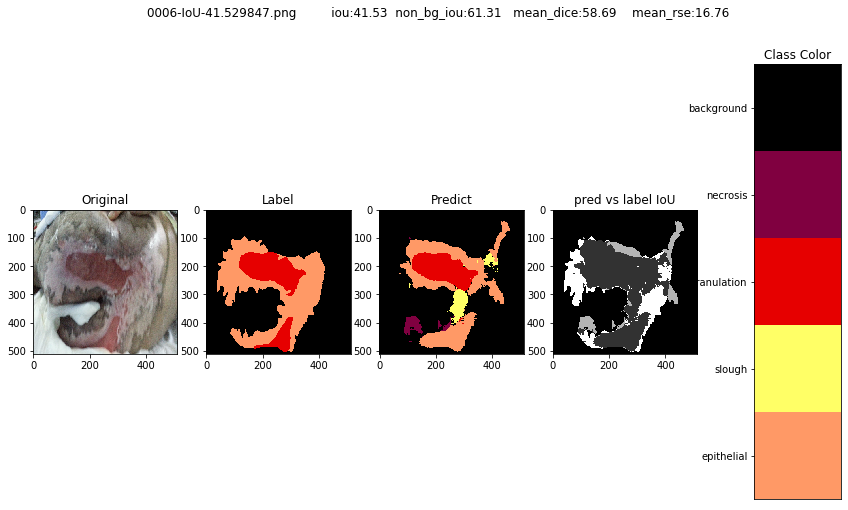

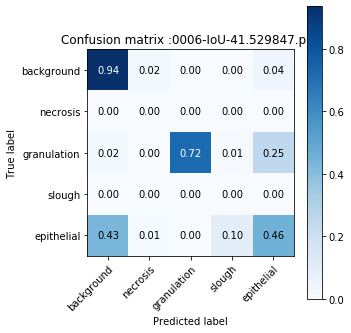

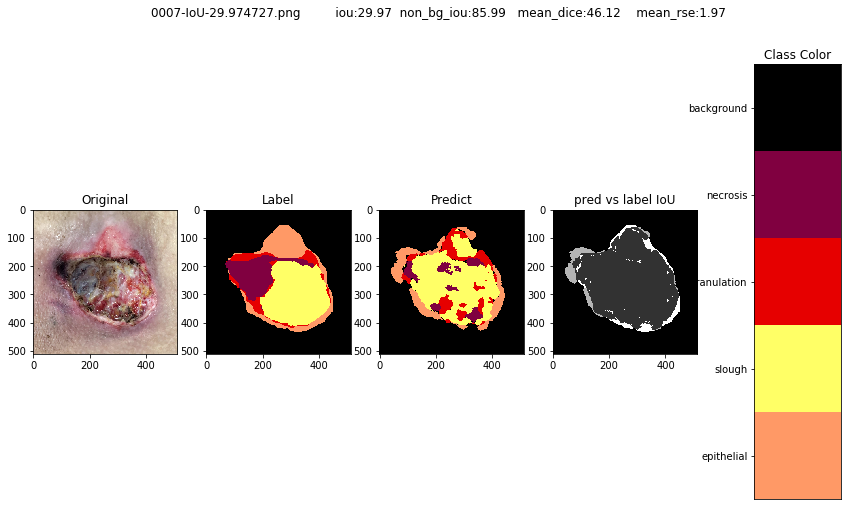

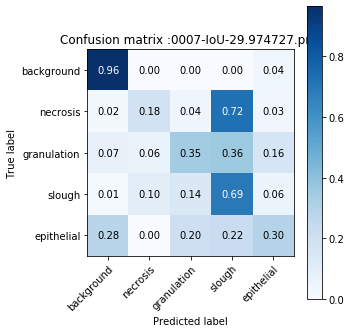

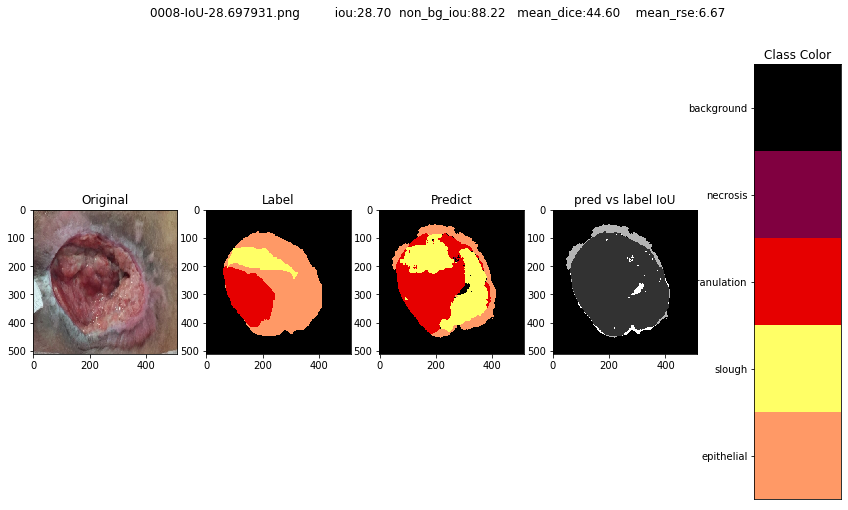

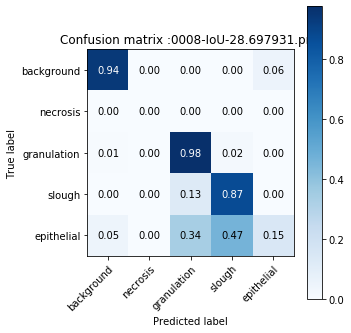

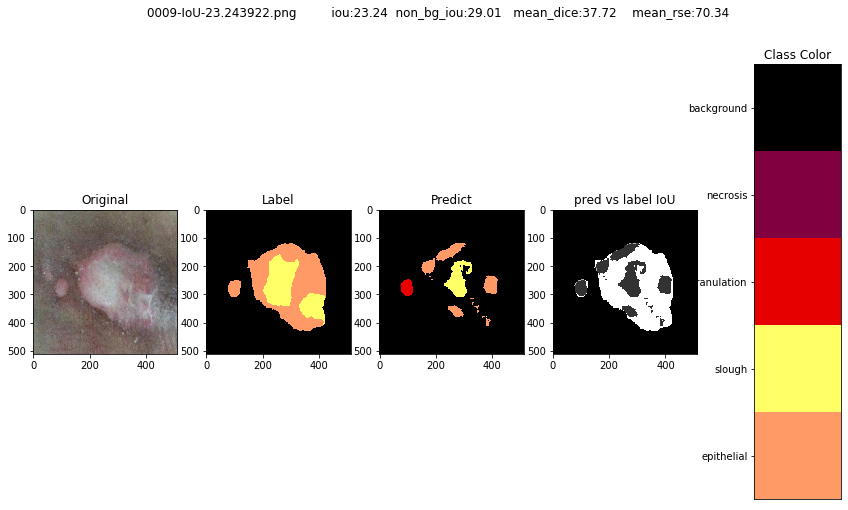

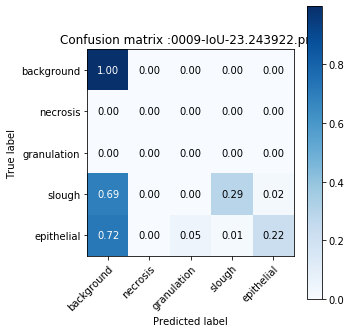

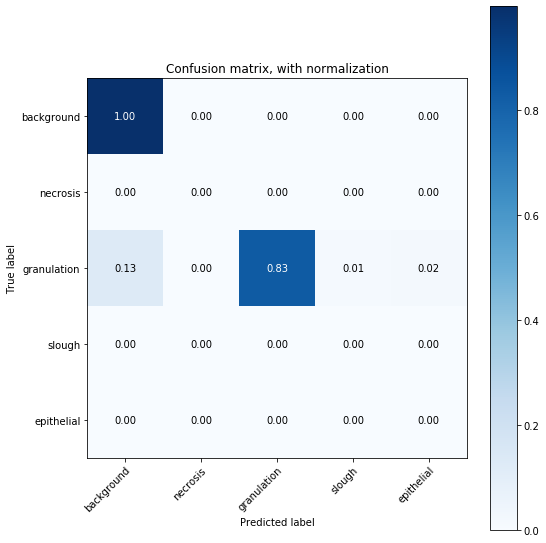

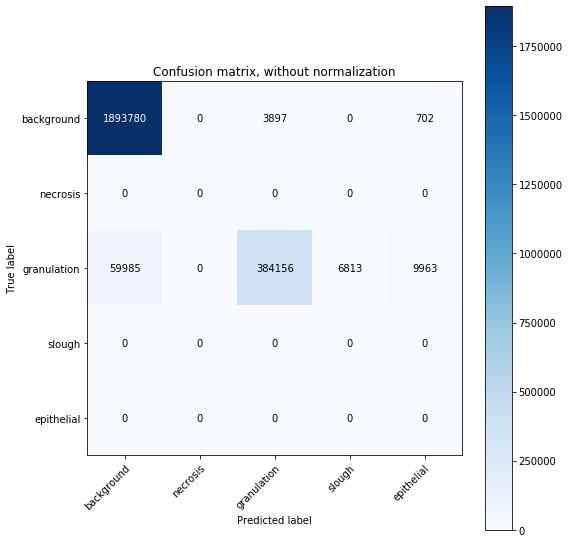

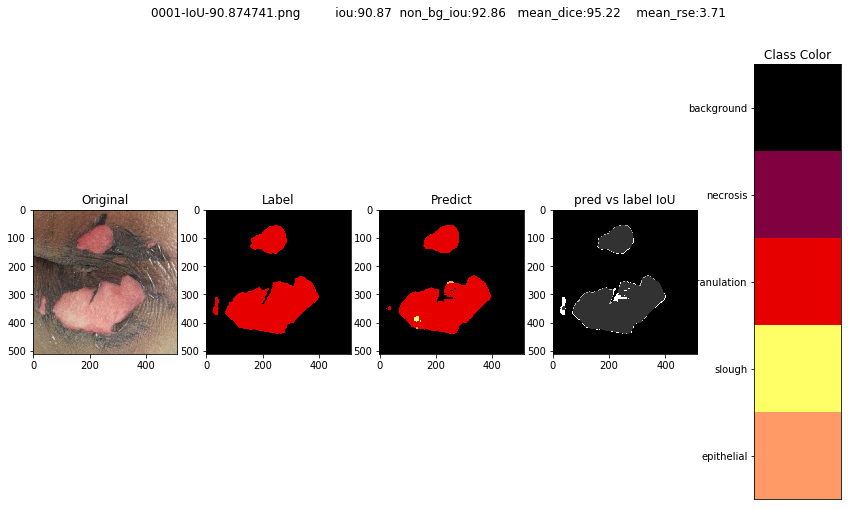

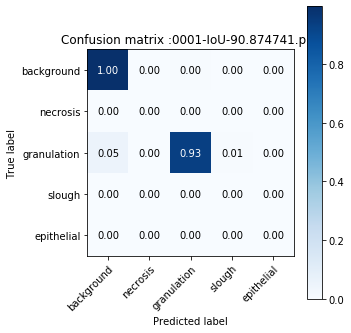

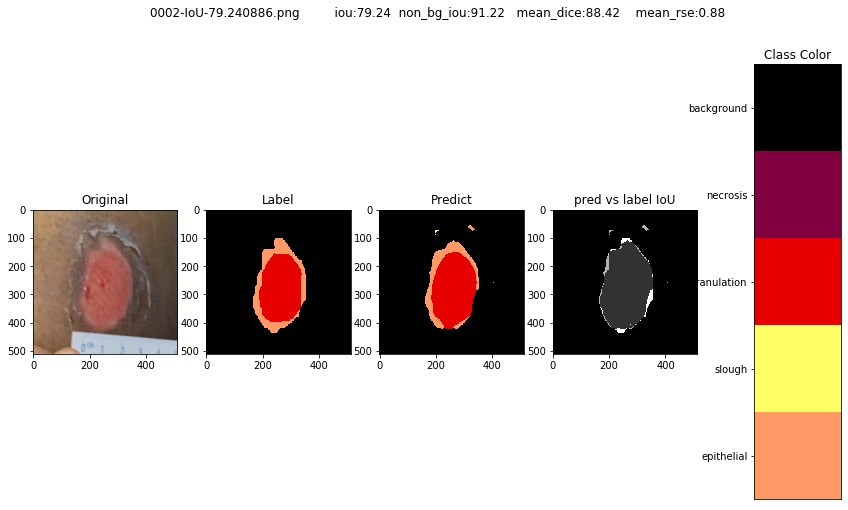

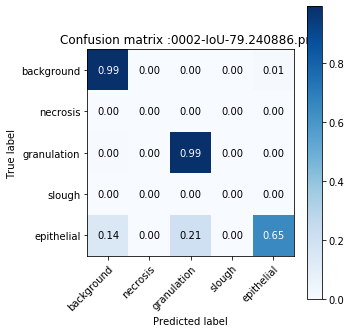

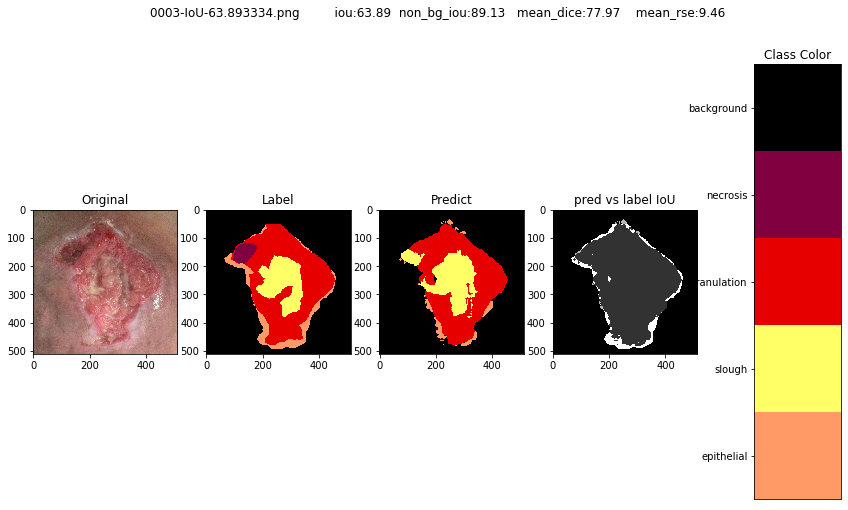

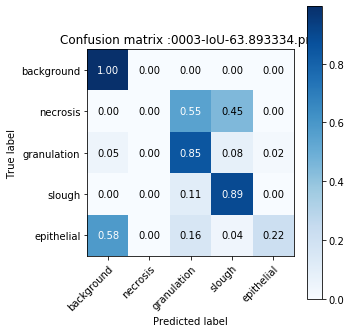

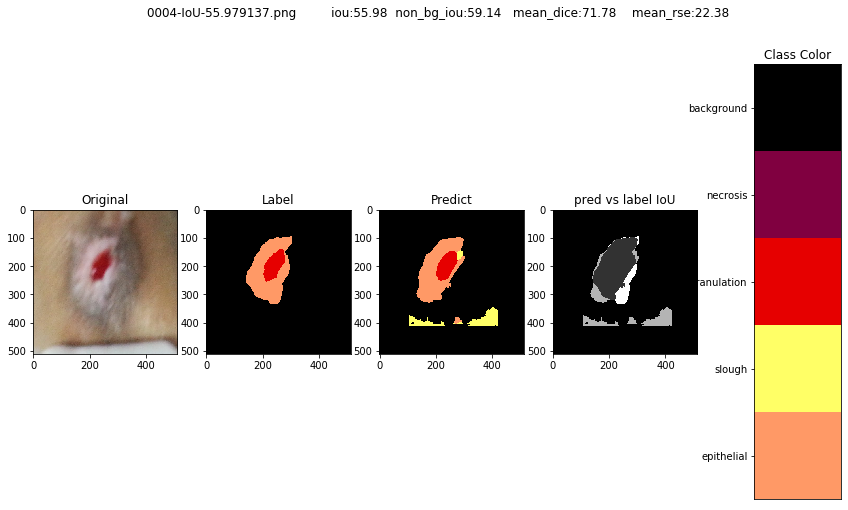

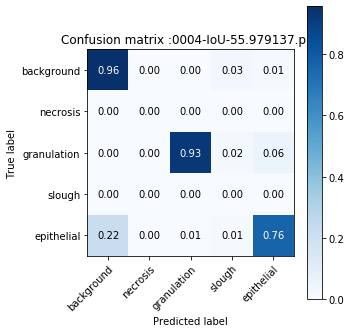

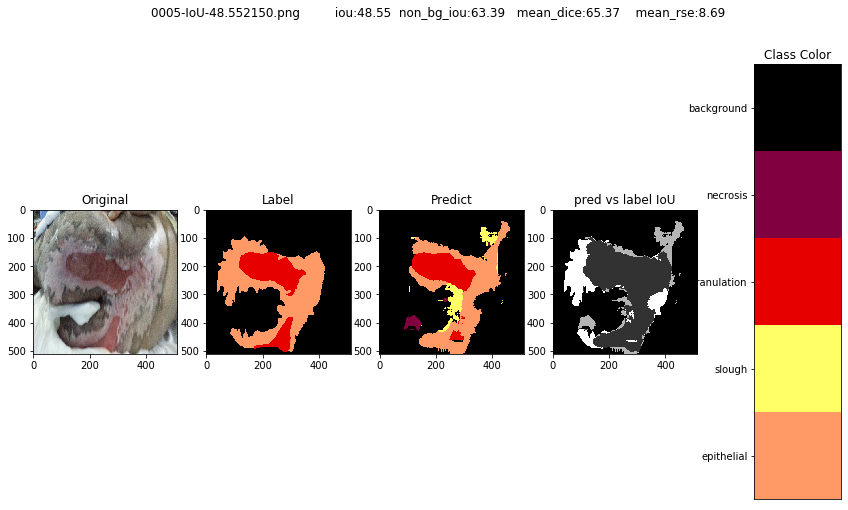

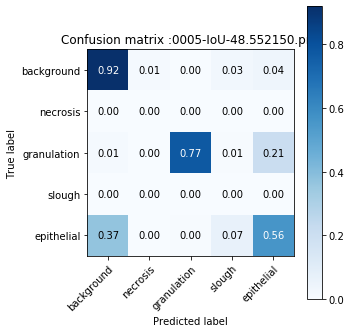

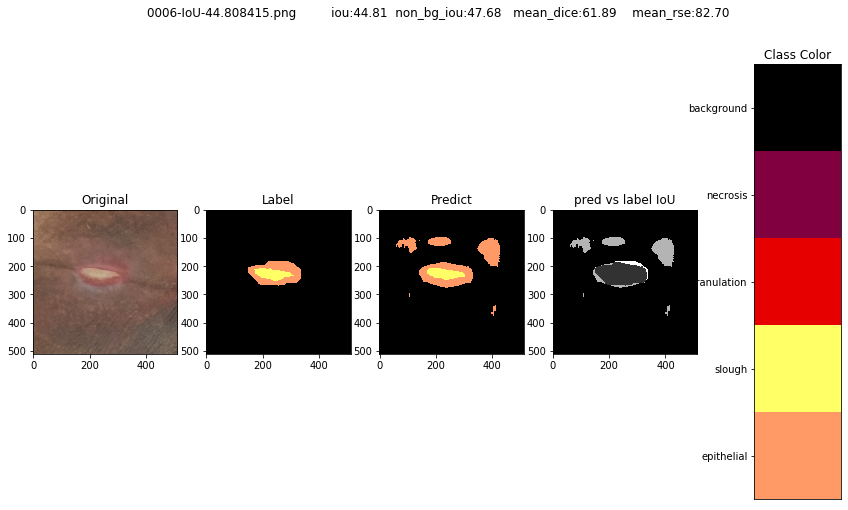

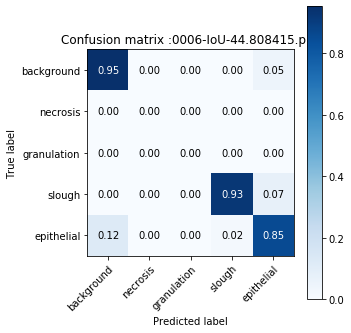

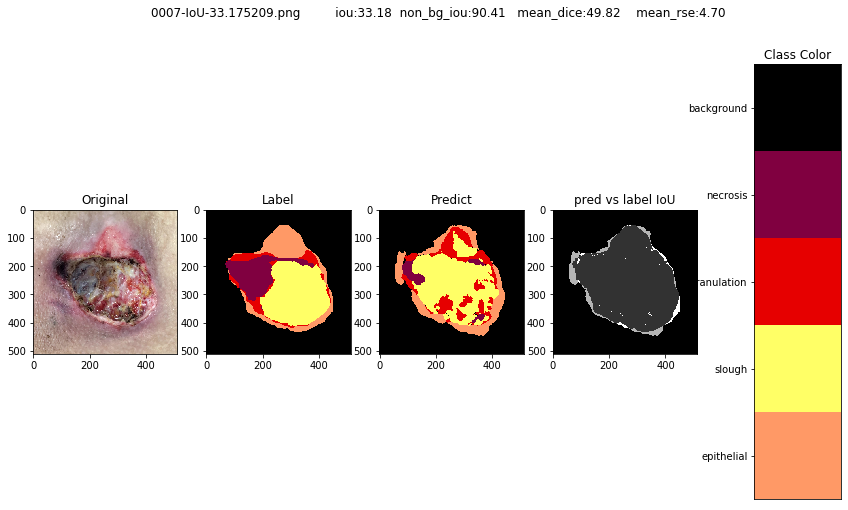

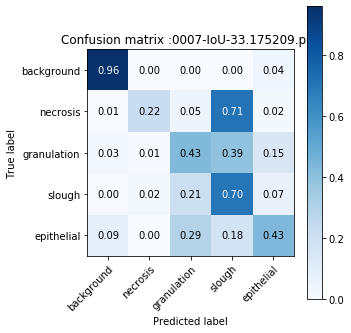

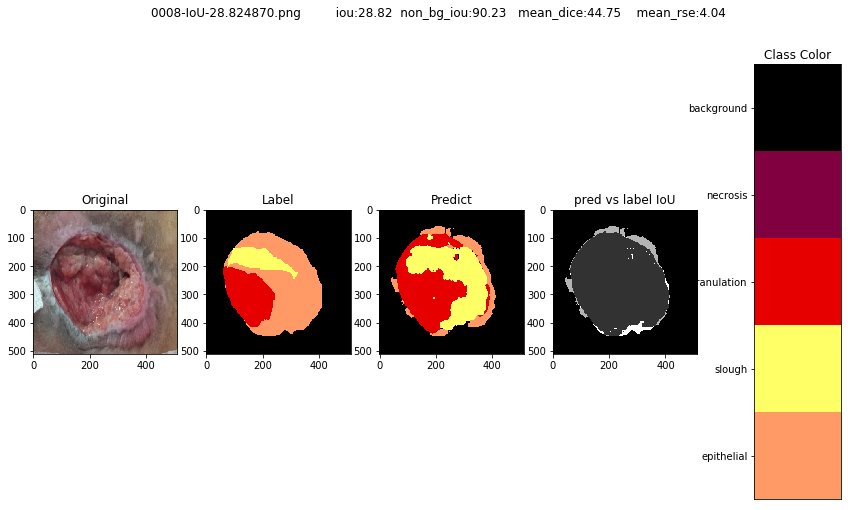

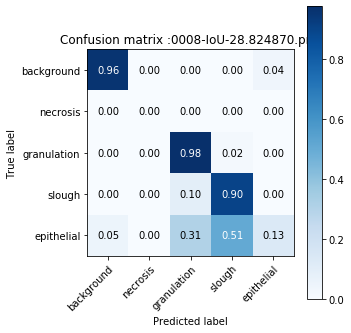

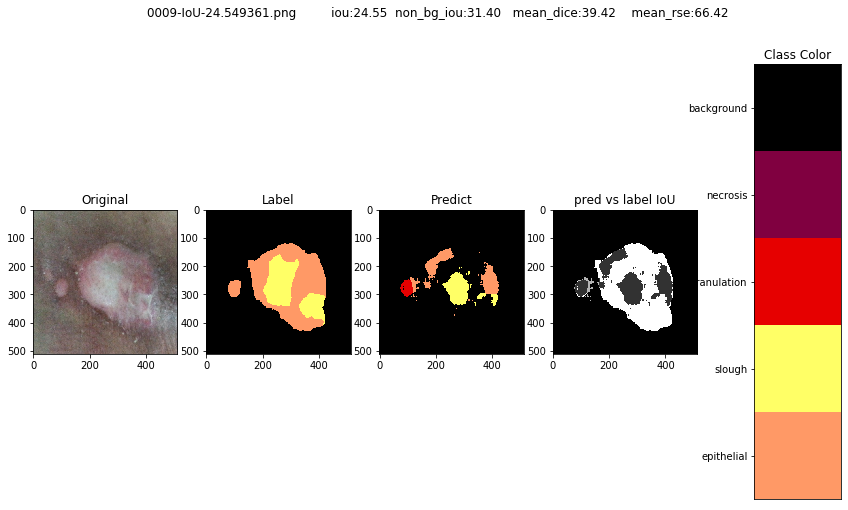

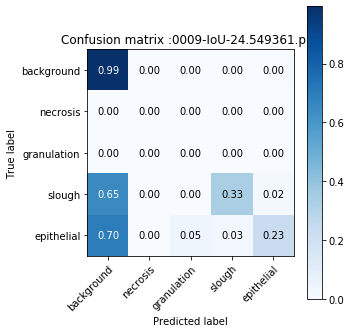

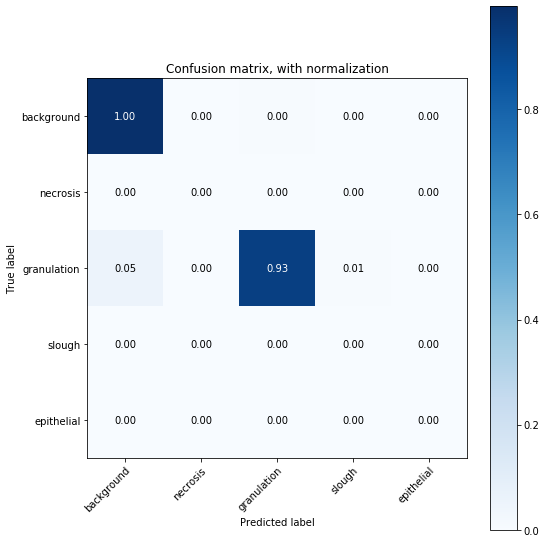

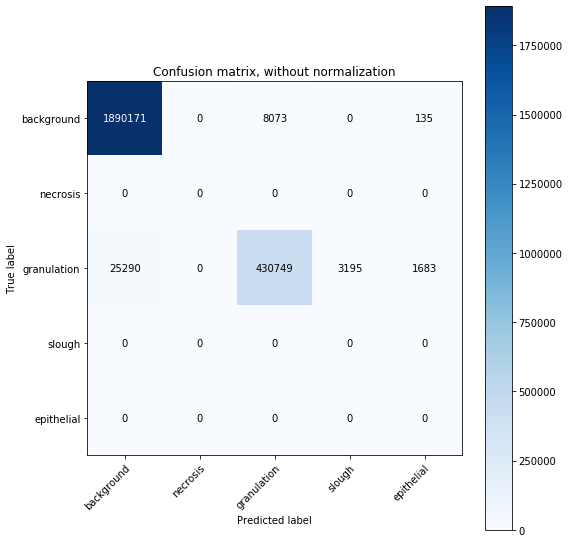

In [18]:
training_name     = "wound_rajavithi_korean_medetec"
testing_name      = "testing"
experiment_number = "0005"
fold_dirs         = ["5", "6", "7"]
test(experiment_number, fold_dirs, training_name, testing_name)